In [1]:
import sys
import importlib
import datetime

import numpy as np
import pandas as pd
import xarray as xr
import pvlib as pv
import matplotlib.pyplot as plt
import scipy.ndimage.filters as filters

In [2]:
%matplotlib inline

In [3]:
sys.path.append('/home/travis/python_code/letkf_forecasting/')
import letkf_forecasting as lf
import prepare_sat_data as prep

In [ ]:
sys.path.append('/home/travis/python_code/satellite_irradiance_optimal_interpolation/satoi/oi/')
import oi as oi

In [17]:
importlib.reload(prep)

<module 'prepare_sat_data' from '/home/travis/python_code/letkf_forecasting/prepare_sat_data.py'>

In [5]:
importlib.reload(prep)
files = prep.get_all_files()

30.5435212539
33.8708869527
-112.863935501
-108.929015092


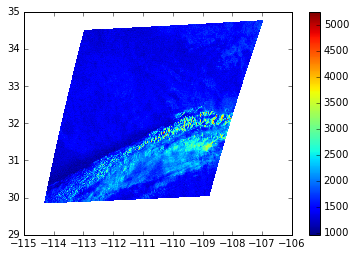

(308100, 2)
(308100,)


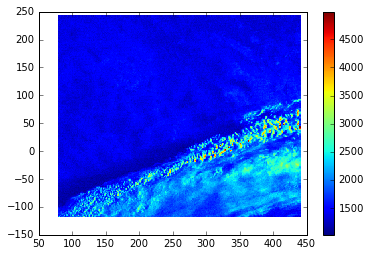

In [143]:
importlib.reload(prep)
prep.main(180, 1, x_slice, y_slice)

In [141]:
y_slice = slice(900 - 100, 1090 + 100)
x_slice = slice(2200 - 200, 2570 + 220)

In [84]:
sat0 = xr.open_dataset(files[0])

In [97]:
sat = sat0.isel(yc=y_slice, xc=x_slice)

In [104]:
sat.lat.values.shape

(390, 670)

In [138]:
that = sat0['lon'].isel(xc = x_slice, yc = y_slice).values

In [140]:
that[:, -1]

array([-106.97420502, -106.97969055, -106.98517609, -106.99065399,
       -106.9961319 , -107.00159454, -107.00705719, -107.01251984,
       -107.01796722, -107.02341461, -107.028862  , -107.03430176,
       -107.03973389, -107.04515839, -107.05058289, -107.05599976,
       -107.061409  , -107.06681824, -107.07221985, -107.07762146,
       -107.08301544, -107.08840179, -107.09378052, -107.09915924,
       -107.10453033, -107.10990143, -107.11526489, -107.12062073,
       -107.12597656, -107.13132477, -107.13666534, -107.14200592,
       -107.14733887, -107.15266418, -107.1579895 , -107.16330719,
       -107.16862488, -107.17393494, -107.17923737, -107.18453217,
       -107.18982697, -107.19512177, -107.20040131, -107.20568085,
       -107.21096039, -107.21622467, -107.22149658, -107.22675323,
       -107.23200989, -107.23725891, -107.24250793, -107.24774933,
       -107.25298309, -107.25821686, -107.26344299, -107.2686615 ,
       -107.27388   , -107.27909851, -107.28430176, -107.28950

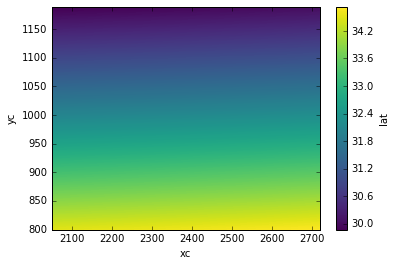

In [54]:
sat0['lat'].isel(xc = x_slice, yc = y_slice).plot()

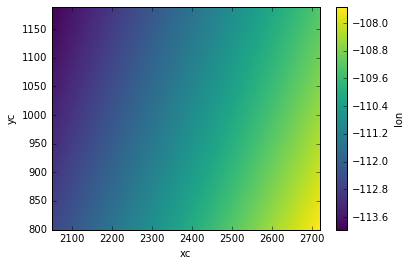

In [55]:
sat0['lon'].isel(xc = x_slice, yc = y_slice).plot()

In [40]:
sat0['lon'].isel(xc = x_slice, yc = y_slice)

<xarray.DataArray 'lon' (yc: 390, xc: 670)>
[261300 values with dtype=float32]
Coordinates:
    lat      (yc, xc) float32 34.5093 34.5095 34.5098 34.5101 34.5104 ...
    lon      (yc, xc) float32 -112.601 -112.594 -112.587 -112.579 -112.572 ...
  * yc       (yc) int64 800 801 802 803 804 805 806 807 808 809 810 811 812 ...
  * xc       (xc) int64 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 ...
Attributes:
    long_name: lon
    units: degrees_east